# 1. import thư viện và load dữ liệu

In [16]:
# Import thư viện
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import random

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [52]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn đến file mnist.zip
# LƯU Ý: Thay đổi đường dẫn nếu bạn đặt mnist.zip ở vị trí khác
ZIP_PATH = '/content/drive/MyDrive/mnist.zip'
EXTRACT_PATH = '/content/mnist'

# Giải nén mnist.zip
import zipfile

if os.path.exists(ZIP_PATH):
    print(f'Tìm thấy file: {ZIP_PATH}')
    print(f'Đang giải nén...')

    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('/content/')

    print(f'Giải nén hoàn tất!')
    print(f'Thư mục dữ liệu: {EXTRACT_PATH}')

    # Kiểm tra cấu trúc
    if os.path.exists(EXTRACT_PATH):
        folders = sorted([f for f in os.listdir(EXTRACT_PATH) if os.path.isdir(os.path.join(EXTRACT_PATH, f))])
        print(f'Các thư mục: {folders}')
    else:
        print('Cấu trúc không đúng, kiểm tra lại file zip')
else:
    print(f'Không tìm thấy {ZIP_PATH}')
    print('Hãy upload file mnist.zip lên Google Drive')

# Thiết lập đường dẫn dữ liệu
DATA_PATH = EXTRACT_PATH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tìm thấy file: /content/drive/MyDrive/mnist.zip
Đang giải nén...
Giải nén hoàn tất!
Thư mục dữ liệu: /content/mnist
Các thư mục: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# 2. Khám phá và tiền xử lý ảnh

THỐNG KÊ DỮ LIỆU


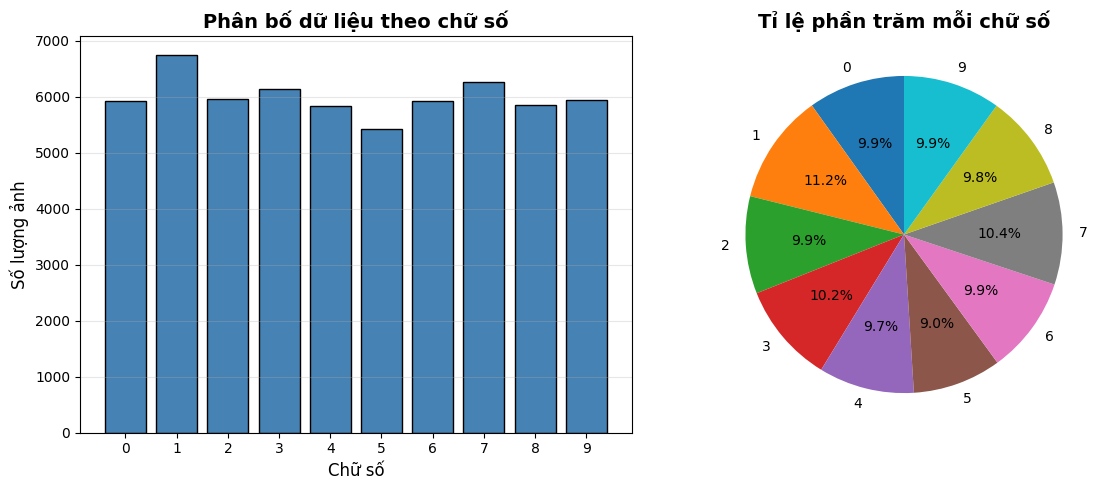

In [53]:
# Đếm số lượng ảnh trong mỗi class
print('=' * 50)
print('THỐNG KÊ DỮ LIỆU')
print('=' * 50)

class_counts = {}
total_images = 0

for digit in range(10):
    digit_path = os.path.join(DATA_PATH, str(digit))
    if os.path.exists(digit_path):
        images = [f for f in os.listdir(digit_path) if f.endswith(('.jpg', '.png'))]
        count = len(images)
        class_counts[digit] = count
        total_images += count

# Visualize phân bố dữ liệu
plt.figure(figsize=(12, 5))

# Bar chart
plt.subplot(1, 2, 1)
digits = list(class_counts.keys())
counts = list(class_counts.values())
plt.bar(digits, counts, color='steelblue', edgecolor='black')
plt.xlabel('Chữ số', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.title('Phân bố dữ liệu theo chữ số', fontsize=14, fontweight='bold')
plt.xticks(digits)
plt.grid(axis='y', alpha=0.3)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(counts, labels=digits, autopct='%1.1f%%', startangle=90)
plt.title('Tỉ lệ phần trăm mỗi chữ số', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Kích thước ảnh mẫu: (32, 32)


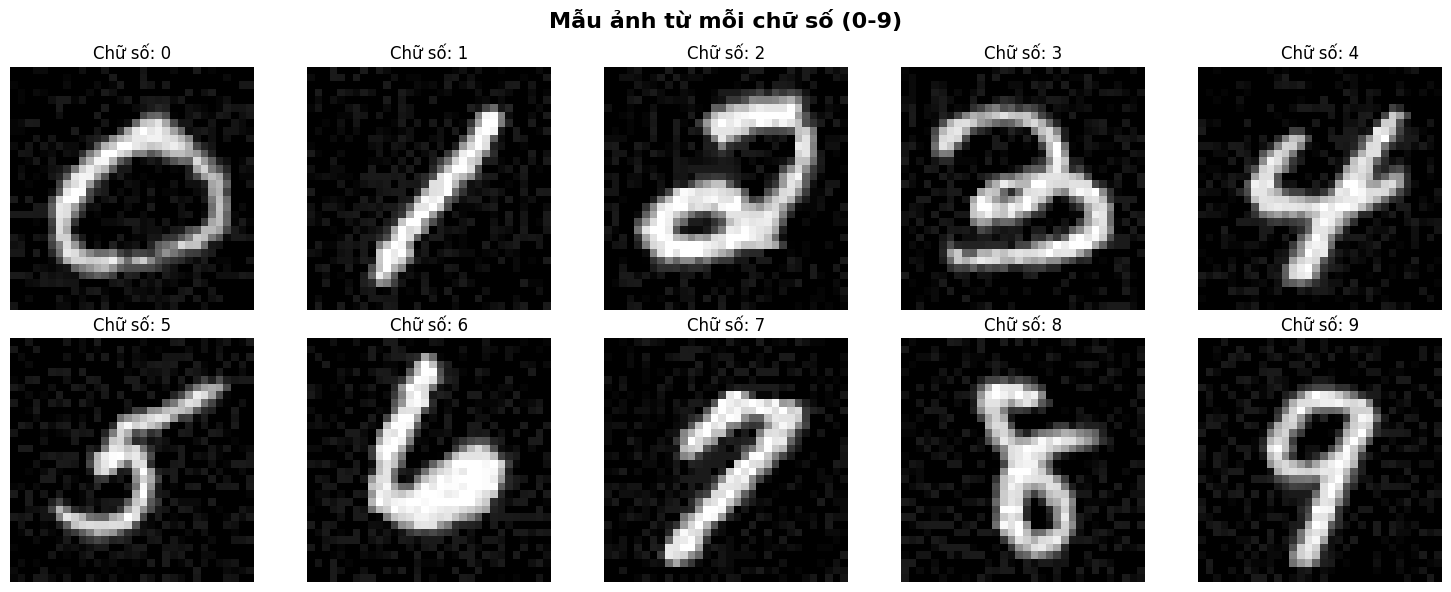

In [54]:
# Hiển thị mẫu ảnh từ mỗi class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Mẫu ảnh từ mỗi chữ số (0-9)', fontsize=16, fontweight='bold')
axes = axes.ravel()

for digit in range(10):
    digit_path = os.path.join(DATA_PATH, str(digit))
    images = [f for f in os.listdir(digit_path) if f.endswith(('.jpg', '.png'))]

    if images:
        # Lấy ngẫu nhiên 1 ảnh
        sample_img = random.choice(images)
        img_path = os.path.join(digit_path, sample_img)
        img = Image.open(img_path)

        # Kiểm tra kích thước ảnh
        if digit == 0:
            print(f'Kích thước ảnh mẫu: {img.size}')

        axes[digit].imshow(img, cmap='gray')
        axes[digit].set_title(f'Chữ số: {digit}', fontsize=12)
        axes[digit].axis('off')

plt.tight_layout()
plt.show()

# 3. Tạo Dataset với Image Preprocessing

In [56]:
# Custom Dataset với Image Preprocessing
class DigitsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, apply_preprocessing=True):
        """
        Args:
            image_paths: List đường dẫn đến ảnh
            labels: List nhãn tương ứng
            transform: Các phép biến đổi ảnh (augmentation)
            apply_preprocessing: Có áp dụng tiền xử lý ảnh không
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.apply_preprocessing = apply_preprocessing

    def preprocess_image(self, img_array):
        """
        Áp dụng các kỹ thuật xử lý ảnh để cải thiện chất lượng
        """
        # 1. Denoise bằng Gaussian Blur
        img_denoised = cv2.GaussianBlur(img_array, (3, 3), 0)

        # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
        # Cải thiện độ tương phản cục bộ
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
        img_enhanced = clahe.apply(img_denoised)

        # 3. Morphological Operations để làm rõ nét chữ số
        kernel = np.ones((2, 2), np.uint8)
        img_morph = cv2.morphologyEx(img_enhanced, cv2.MORPH_CLOSE, kernel)

        return img_morph

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load ảnh
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('L')  # Convert sang grayscale

            # Áp dụng preprocessing nếu cần
            if self.apply_preprocessing:
                img_array = np.array(image)
                img_array = self.preprocess_image(img_array)
                image = Image.fromarray(img_array)

            # Apply transforms (augmentation)
            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]

            return image, label
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')
            # Return ảnh trắng nếu lỗi
            return torch.zeros(1, 28, 28), 0

print('DigitsDataset class với Image Preprocessing đã được định nghĩa')

DigitsDataset class với Image Preprocessing đã được định nghĩa


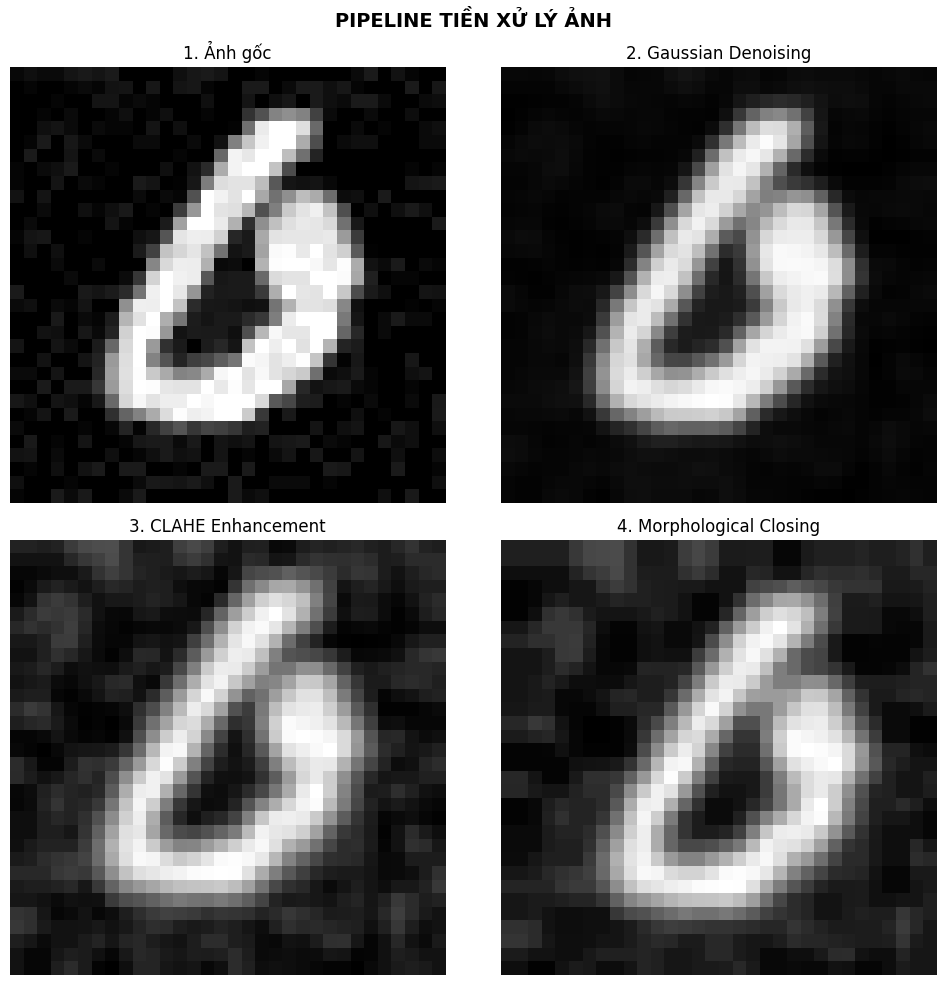

Pipeline tiền xử lý ảnh:
   1. Gaussian Blur - Giảm nhiễu
   2. CLAHE - Cải thiện độ tương phản
   3. Morphological Closing - Làm rõ nét


In [57]:
# So sánh ảnh gốc và ảnh sau preprocessing
# Lấy 1 ảnh mẫu
sample_img_path = None
for digit in range(10):
    digit_path = os.path.join(DATA_PATH, str(digit))
    if os.path.exists(digit_path):
        images = [f for f in os.listdir(digit_path) if f.endswith(('.jpg', '.png'))]
        if images:
            sample_img_path = os.path.join(digit_path, images[0])
            break

if sample_img_path:
    # Ảnh gốc
    img_original = Image.open(sample_img_path).convert('L')
    img_array = np.array(img_original)

    # Áp dụng preprocessing
    img_denoised = cv2.GaussianBlur(img_array, (3, 3), 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    img_clahe = clahe.apply(img_denoised)

    kernel = np.ones((2, 2), np.uint8)
    img_final = cv2.morphologyEx(img_clahe, cv2.MORPH_CLOSE, kernel)

    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('PIPELINE TIỀN XỬ LÝ ẢNH', fontsize=14, fontweight='bold')

    axes[0, 0].imshow(img_array, cmap='gray')
    axes[0, 0].set_title('1. Ảnh gốc')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img_denoised, cmap='gray')
    axes[0, 1].set_title('2. Gaussian Denoising')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(img_clahe, cmap='gray')
    axes[1, 0].set_title('3. CLAHE Enhancement')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(img_final, cmap='gray')
    axes[1, 1].set_title('4. Morphological Closing')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    print('Pipeline tiền xử lý ảnh:')
    print('   1. Gaussian Blur - Giảm nhiễu')
    print('   2. CLAHE - Cải thiện độ tương phản')
    print('   3. Morphological Closing - Làm rõ nét')
else:
    print('Không tìm thấy ảnh mẫu trong DATA_PATH')

In [58]:
# Tạo danh sách đường dẫn và nhãn
print('Đang tạo danh sách ảnh và nhãn...')

all_image_paths = []
all_labels = []

for digit in range(10):
    digit_path = os.path.join(DATA_PATH, str(digit))
    images = [f for f in os.listdir(digit_path) if f.endswith(('.jpg', '.png'))]

    for img_name in images:
        img_path = os.path.join(digit_path, img_name)
        all_image_paths.append(img_path)
        all_labels.append(digit)

# Chia train/validation/test
print('Đang chia dữ liệu...')

# Train: 70%, Val: 15%, Test: 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels,
    test_size=0.3,
    random_state=42,
    stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print('=' * 50)
print(f'Train set: {len(train_paths):,} ảnh')
print(f'Val set: {len(val_paths):,} ảnh')
print(f'Test set: {len(test_paths):,} ảnh')
print('=' * 50)

Đang tạo danh sách ảnh và nhãn...
Đang chia dữ liệu...
Train set: 42,000 ảnh
Val set: 9,000 ảnh
Test set: 9,000 ảnh


In [60]:
# Data Augmentation và Transforms
# Augmentation vừa phải cho training
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    # Augmentation techniques (giảm cường độ)
    transforms.RandomRotation(10),  # Xoay ngẫu nhiên ±10 độ
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),    # Dịch chuyển 10%
        scale=(0.9, 1.1),        # Scale 90%-110%
        shear=8                   # Shear transform
    ),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.25),  # Perspective transform
    transforms.ToTensor(),
    # Random noise (custom) - giảm noise
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.03),  # Gaussian noise
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean, std
])

test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print('Transforms với Data Augmentation')
print('   - Rotation: ±10°')
print('   - Translation: ±10%')
print('   - Scaling: 90%-110%')
print('   - Shearing: ±8°')
print('   - Perspective distortion (reduced)')
print('   - Gaussian noise (reduced)')

Transforms với Data Augmentation
   - Rotation: ±10°
   - Translation: ±10%
   - Scaling: 90%-110%
   - Shearing: ±8°
   - Perspective distortion (reduced)
   - Gaussian noise (reduced)


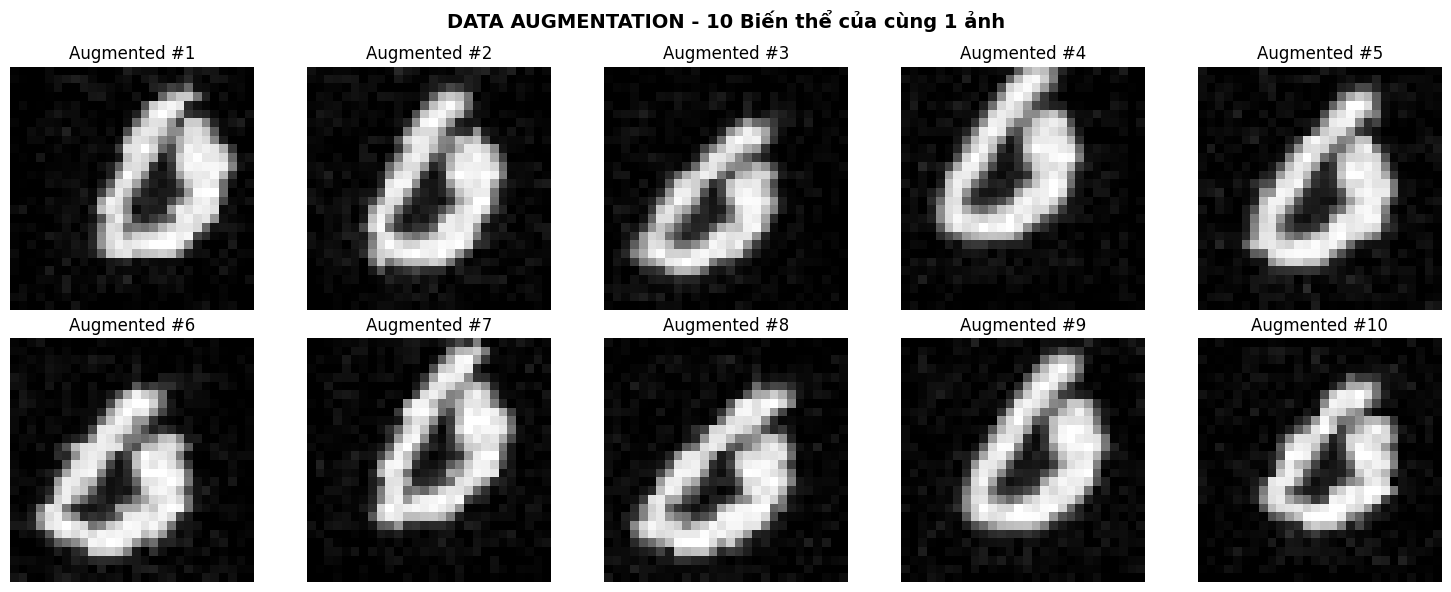

Data Augmentation giúp model học được nhiều biến thể khác nhau


In [61]:
# Visualize augmentation effects
# Lấy 1 ảnh mẫu
sample_img_path = None
for digit in range(10):
    digit_path = os.path.join(DATA_PATH, str(digit))
    if os.path.exists(digit_path):
        images = [f for f in os.listdir(digit_path) if f.endswith(('.jpg', '.png'))]
        if images:
            sample_img_path = os.path.join(digit_path, images[0])
            break

if sample_img_path:
    original_img = Image.open(sample_img_path).convert('L')

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('DATA AUGMENTATION - 10 Biến thể của cùng 1 ảnh', fontsize=14, fontweight='bold')
    axes = axes.ravel()

    for i in range(10):
        # Apply transform
        img_tensor = train_transform(original_img)

        # Denormalize để hiển thị
        img_denorm = img_tensor * 0.3081 + 0.1307
        img_denorm = torch.clamp(img_denorm, 0, 1)

        axes[i].imshow(img_denorm.squeeze(), cmap='gray')
        axes[i].set_title(f'Augmented #{i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print('Data Augmentation giúp model học được nhiều biến thể khác nhau')
else:
    print('Không tìm thấy ảnh mẫu trong DATA_PATH')

In [62]:
# Tạo Datasets
train_dataset = DigitsDataset(train_paths, train_labels, transform=train_transform)
val_dataset = DigitsDataset(val_paths, val_labels, transform=test_transform)
test_dataset = DigitsDataset(test_paths, test_labels, transform=test_transform)

print('Datasets đã được tạo')

Datasets đã được tạo


In [64]:
# Tạo DataLoaders
BATCH_SIZE = 128  # Tăng batch size để tận dụng GPU

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 để tránh lỗi multiprocessing trên Colab
    pin_memory=True  # Tăng tốc transfer sang GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print('✅ DataLoaders đã sẵn sàng')
print(f'Số batch mỗi epoch (train): {len(train_loader)}')
print(f'Số batch mỗi epoch (val): {len(val_loader)}')

✅ DataLoaders đã sẵn sàng
Số batch mỗi epoch (train): 329
Số batch mỗi epoch (val): 71


# 4. Định nghĩa CNN model

In [65]:
class DigitCNN(nn.Module):
    """
    Convolutional Neural Network cho nhận dạng chữ số viết tay

    Kiến trúc:
    - 3 Convolutional layers để trích chọn đặc trưng
    - MaxPooling để giảm kích thước
    - Fully Connected layers để phân loại
    - Dropout để tránh overfitting
    """

    def __init__(self, num_classes=10):
        super(DigitCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 14x14 -> 7x7

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 7x7 -> 7x7
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # 7x7 -> 3x3

        # Fully Connected Layers
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

# Tạo model
model = DigitCNN(num_classes=10).to(device)

# Đếm số parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('=' * 60)
print('THÔNG TIN MODEL')
print('=' * 60)
print(model)
print('=' * 60)
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print('=' * 60)

THÔNG TIN MODEL
DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.3, inplace=F

# 5. Training

In [66]:
# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
PATIENCE = 5  # Early stopping patience

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
)

print('Training setup hoàn tất')
print(f'Learning Rate: {LEARNING_RATE}')
print(f'Epochs: {NUM_EPOCHS}')
print(f'Optimizer: Adam')
print(f'Loss: CrossEntropyLoss')

Training setup hoàn tất
Learning Rate: 0.001
Epochs: 20
Optimizer: Adam
Loss: CrossEntropyLoss


In [67]:
# Training và Validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': running_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

print('Training functions đã được định nghĩa')

Training functions đã được định nghĩa


In [68]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0.0
best_model_path = 'best_digit_cnn.pth'
patience_counter = 0

print('\n' + '=' * 70)
print('BẮT ĐẦU TRAINING')
print('=' * 70)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}]')
    print('-' * 70)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print results
    print(f'\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'\nSaved best model with Val Acc: {val_acc:.2f}%')
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break

print('\n' + '=' * 70)
print(f'TRAINING HOÀN TẤT!')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
print('=' * 70)


BẮT ĐẦU TRAINING

Epoch [1/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.3787 | Train Acc: 87.99%
Val Loss: 0.0627 | Val Acc: 98.13%

Saved best model with Val Acc: 98.13%

Epoch [2/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.1249 | Train Acc: 96.10%
Val Loss: 0.0450 | Val Acc: 98.39%

Saved best model with Val Acc: 98.39%

Epoch [3/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0919 | Train Acc: 97.06%
Val Loss: 0.0265 | Val Acc: 99.10%

Saved best model with Val Acc: 99.10%

Epoch [4/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0785 | Train Acc: 97.60%
Val Loss: 0.0479 | Val Acc: 98.52%

Epoch [5/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0691 | Train Acc: 97.82%
Val Loss: 0.0197 | Val Acc: 99.40%

Saved best model with Val Acc: 99.40%

Epoch [6/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0633 | Train Acc: 98.05%
Val Loss: 0.0149 | Val Acc: 99.53%

Saved best model with Val Acc: 99.53%

Epoch [7/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0602 | Train Acc: 98.16%
Val Loss: 0.0235 | Val Acc: 99.32%

Epoch [8/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0549 | Train Acc: 98.30%
Val Loss: 0.0178 | Val Acc: 99.38%

Epoch [9/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0511 | Train Acc: 98.40%
Val Loss: 0.0153 | Val Acc: 99.51%

Epoch [10/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0512 | Train Acc: 98.38%
Val Loss: 0.0162 | Val Acc: 99.51%

Epoch [11/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0368 | Train Acc: 98.83%
Val Loss: 0.0112 | Val Acc: 99.63%

Saved best model with Val Acc: 99.63%

Epoch [12/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0346 | Train Acc: 98.95%
Val Loss: 0.0096 | Val Acc: 99.69%

Saved best model with Val Acc: 99.69%

Epoch [13/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0334 | Train Acc: 98.98%
Val Loss: 0.0125 | Val Acc: 99.57%

Epoch [14/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0320 | Train Acc: 99.00%
Val Loss: 0.0103 | Val Acc: 99.68%

Epoch [15/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0320 | Train Acc: 99.00%
Val Loss: 0.0096 | Val Acc: 99.71%

Saved best model with Val Acc: 99.71%

Epoch [16/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0337 | Train Acc: 98.91%
Val Loss: 0.0106 | Val Acc: 99.71%

Epoch [17/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0307 | Train Acc: 98.99%
Val Loss: 0.0090 | Val Acc: 99.72%

Saved best model with Val Acc: 99.72%

Epoch [18/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0297 | Train Acc: 99.01%
Val Loss: 0.0105 | Val Acc: 99.70%

Epoch [19/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0309 | Train Acc: 99.04%
Val Loss: 0.0112 | Val Acc: 99.69%

Epoch [20/20]
----------------------------------------------------------------------


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


Train Loss: 0.0287 | Train Acc: 99.14%
Val Loss: 0.0089 | Val Acc: 99.73%

Saved best model with Val Acc: 99.73%

TRAINING HOÀN TẤT!
Best Validation Accuracy: 99.73%


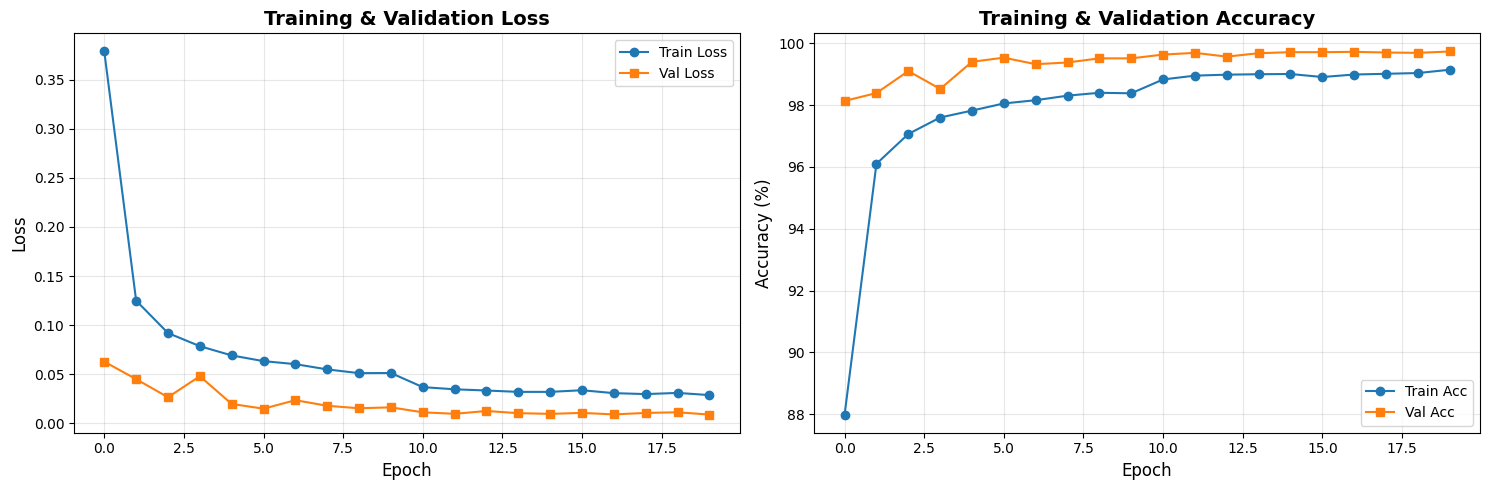

Training curves đã được lưu: training_history.png


In [69]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('Training curves đã được lưu: training_history.png')

# 6. Kiểm tra trên tập test

In [72]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Test
test_loss, test_acc = validate(model, test_loader, criterion, device)

print('\n' + '=' * 60)
print('TEST SET RESULTS')
print('=' * 60)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')
print('=' * 60)

Validation:   0%|          | 0/71 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss: 0.0076
Test Accuracy: 99.72%



CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9989    0.9977    0.9983       888
           1     0.9960    0.9970    0.9965      1011
           2     0.9989    0.9910    0.9949       893
           3     0.9978    0.9978    0.9978       920
           4     0.9989    0.9977    0.9983       877
           5     0.9963    1.0000    0.9982       813
           6     1.0000    0.9966    0.9983       888
           7     0.9979    0.9968    0.9973       940
           8     0.9966    0.9977    0.9972       877
           9     0.9911    1.0000    0.9955       893

    accuracy                         0.9972      9000
   macro avg     0.9972    0.9973    0.9972      9000
weighted avg     0.9972    0.9972    0.9972      9000



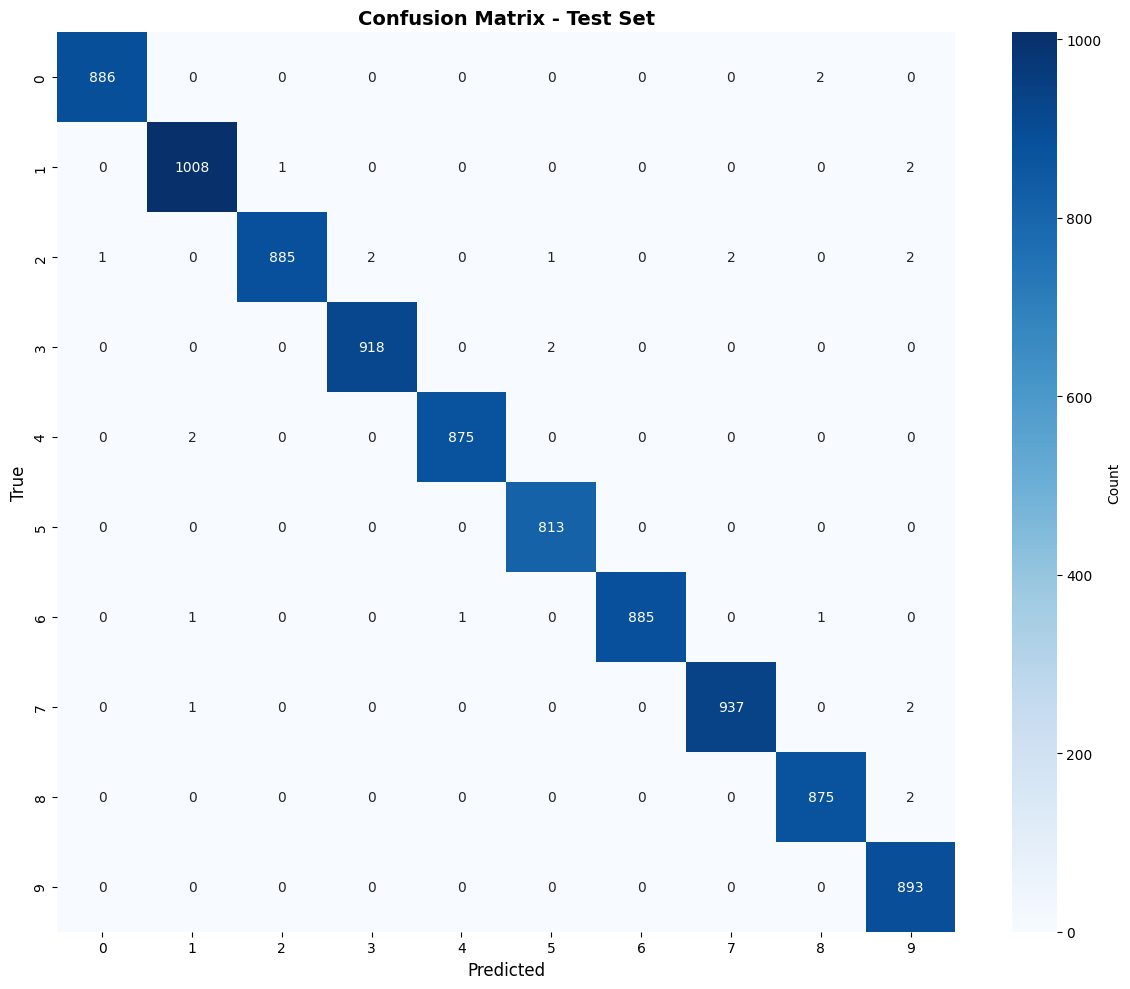


Confusion matrix đã được lưu: confusion_matrix.png


In [73]:
# Detailed metrics per class
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Collecting predictions'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print('\n' + '=' * 60)
print('CLASSIFICATION REPORT')
print('=' * 60)
print(classification_report(all_labels, all_preds,
                            target_names=[str(i) for i in range(10)],
                            digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nConfusion matrix đã được lưu: confusion_matrix.png')

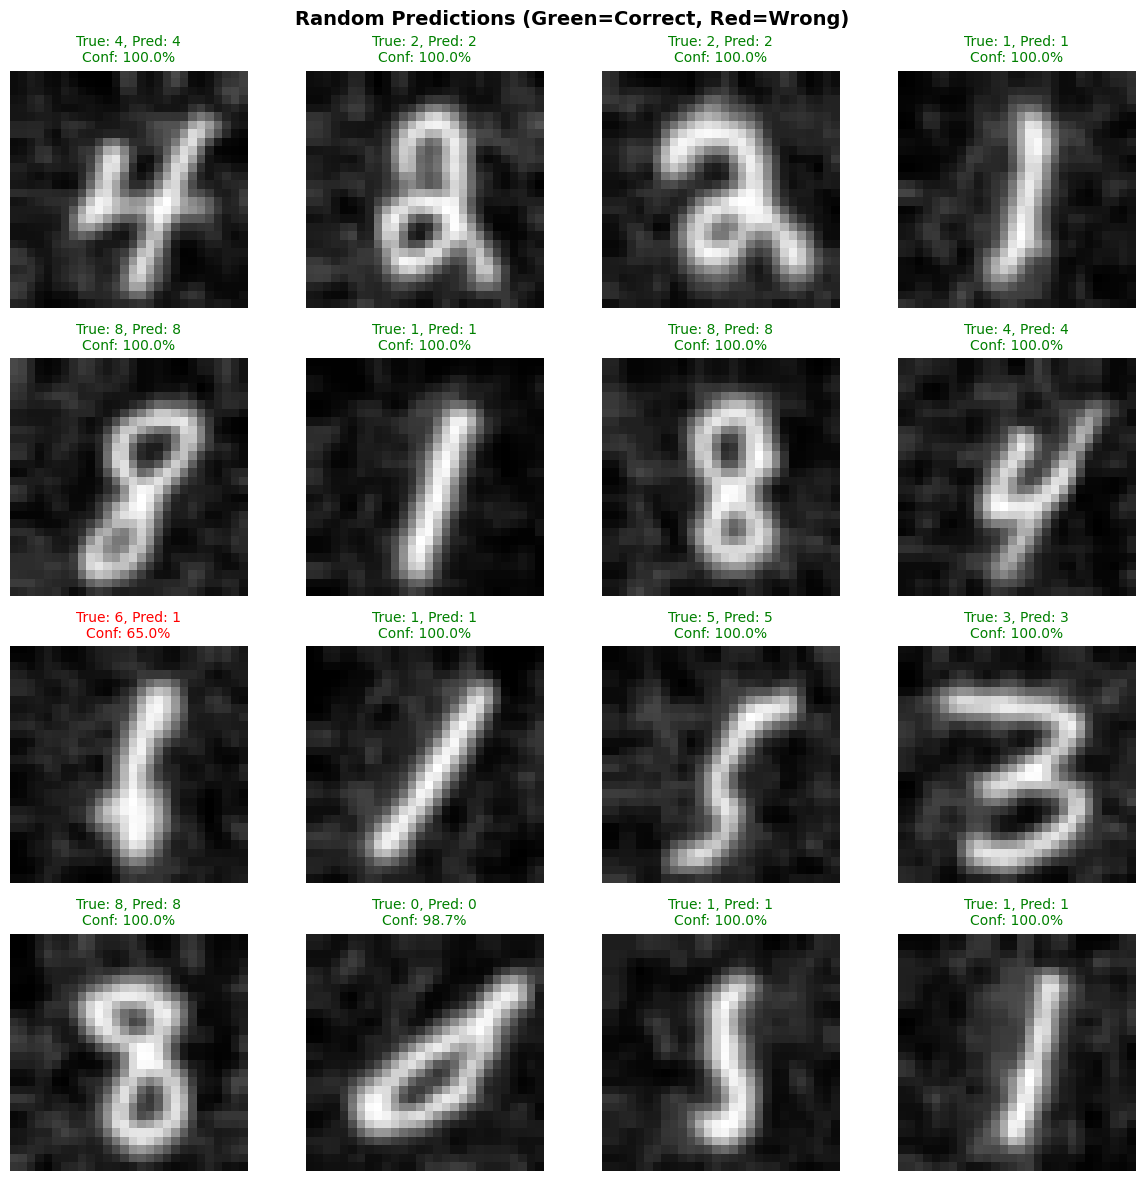

✅ Predictions đã được lưu: predictions_sample.png


In [76]:
# Hiển thị random predictions
def show_predictions(model, dataset, device, num_samples=16):
    model.eval()

    # Random samples
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]

            # Predict
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            _, predicted = output.max(1)
            pred_label = predicted.item()

            # Get confidence
            probs = torch.softmax(output, dim=1)
            confidence = probs[0][pred_label].item() * 100

            # Denormalize image
            img_display = image.squeeze().cpu().numpy()
            img_display = img_display * 0.3081 + 0.1307  # Denormalize
            img_display = np.clip(img_display, 0, 1)

            # Plot
            axes[i].imshow(img_display, cmap='gray')

            # Title color: green if correct, red if wrong
            color = 'green' if pred_label == true_label else 'red'
            axes[i].set_title(
                f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.1f}%',
                color=color,
                fontsize=10
            )
            axes[i].axis('off')

    plt.suptitle('Random Predictions (Green=Correct, Red=Wrong)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('predictions_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

show_predictions(model, test_dataset, device, num_samples=16)
print('✅ Predictions đã được lưu: predictions_sample.png')